# Майнор Интеллектуальный анализ данных / Введение в анализ данных

## Домашнее задание 3. Логистическая регрессия и случайный лес.

В этом задании вам предстоит:
- поработать с логистической регрессией (полная реализация не потребуется, однако можно заработать бонусные баллы)
- воспроизвести подход случайного леса через одно решающее дерево, поэкспериментировать со случайным лесом.

На все вопросы требуется отвечать развёрнуто, аппелируя к полученным значениям или графикам, ответы вписывать в отдельную ячейку, выбрав для неё тип "Markdown". От полноты и качества ответов будет во многом зависеть ваша итоговая оценка.

Задание выполняется самостоятельно, плагиат будет стандартно наказываться лишением всех баллов за задание.
- Максимальная оценка за задание: 10 баллов.
- Дата выдачи: 28.04.2018
- Срок сдачи: 23:59 18.05.2018

In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


## Часть 0. Подготовка данных.

Для наших экспериентов возьмём обучающую выборку [отсюда](https://www.kaggle.com/iabhishekofficial/mobile-price-classification).

In [2]:
train = pd.read_csv('train.csv')

Решается задача многоклассовой классификации — определение ценовой категории телефона. Для простоты перейдём к задаче бинарной классификации — пусть исходные классы 0 и 1 соответствуют классу 0 новой целевой переменной, а остальные классу 1.

Замените целевую переменную, отделите её в отдельную переменную и удалите из исходной выборки.

In [3]:
X = train.drop('price_range', axis=1)
y = train.price_range.values

y[y<=1] = 0
y[y>1] = 1

Разделите выборку на обучающую и тестовую части в соотношении 7 к 3. Для этого можно использовать `train_test_split` из scikit-learn. Не забудьте зафиксировать сид для разбиения.

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state = 0)

## Часть 1. Логистическая регрессия.

[4 балла]

В этой части вы будете обучать самый простой бинарный классификатор — логистическую регрессию. Будем использовать готовую реализацию `LogisticRegression` из scikit-learn.

Логистическая регрессия — линейный метод, то есть в нём предсказание алгоритма вычислаяется как скалярное произведение признаков и весов алгоритма: 

$$
b(x) = w_0 + \langle w, x \rangle = w_0 + \sum_{i=1}^{d} w_i x_i
$$

Для вычисления вероятности положительного класса применяется сигмода. В результате предсказание вероятности принадлежности объекта к положительному классу можно записать как: 

$$
P(y = +1 | x) = \frac{1}{1 + \exp(- w_0 - \langle w, x \rangle )}
$$

Не забывайте, что для линейных методов матрицу объекты-признаки необходимо предварительно нормировать (то есть привести каждый признак к одному и тому же масштабу одним из способов). Для этого можно воспользоваться `StandardScaler` или сделать это вручную.

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Обучите логистическую регрессию. Сделайте предсказания для тестовой части, посчитайте по ним ROC-AUC и Accuracy (порог 0.5). Хорошо ли удаётся предсказывать целевую переменную?

- Да, очень хорошо. Пришлось даже проверять, не включил ли я случайно целевую переменную в тренировочную выборку

Не забывайте, что метод `predict_proba` вычисляет вероятности обоих классов выборки, а в бинарной классификации нас интересует в первую очередь вероятность принадлежности к положительному классу.

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score

logit = LogisticRegression()

logit.fit(X_train, y_train)

predictions = logit.predict_proba(X_test)[:,1]
binary_predictions = (predictions>=0.5).astype(int)

print("ROC-AUC: ", roc_auc_score(y_test, predictions))
print("Accuracy score: ", accuracy_score(y_test,binary_predictions))

ROC-AUC:  0.999487773373
Accuracy score:  0.99


У обученной логистической регрессии есть два аттрибута: `coef_` и `intercept_`, которые соответствуют весам $w$ и $w_0$. Это и есть результат обучения логистической регрессии. Попробуйте с помощью них (с помощью всё той же обученной ранее логистической регрессии) посчитать "сырое" предсказание алгоритма $b(x)$. 

Постройте гистограмму полученных значений и ответьте на вопросы:
- Какие значения принимает такое предсказание?
- Похожи ли эти значения на вероятность классов?

* Такое предсказание принимает любое значение на $(-\infty, +\infty)$
* Нет, это не вероятности классов

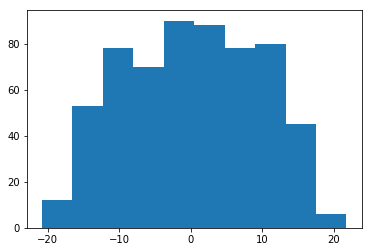

In [7]:
raw_values = X_test.dot(logit.coef_.T) + logit.intercept_
plt.hist(raw_values);

Реализуйте сигмоиду и постройте её график. Что вы можете сказать об этой функции?

- Эта функция очень сильно напоминает функцию распределения непрерывной случайной величины, а также отображает интервал в отрезок $(-\infty, +\infty) \mapsto [0;1]$

In [8]:
def sigmoid(x):
    return 1 / (1+np.exp(-x))

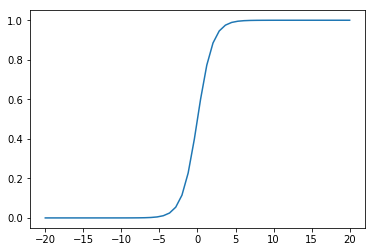

In [9]:
x = np.linspace(-20,20,50)
plt.plot(x, sigmoid(x))

Примените реализованную сигмоиду к $b(x)$. Вы должны получить вероятности принадлежности к положительному классу. Проверьте, что ваши значения совпали с теми, которые получены с помощью `predict_proba`.

In [10]:
raw_predictions = sigmoid(raw_values) # Применяем преобразование сигмоидой

np.all(raw_predictions.flatten() == predictions) # Проверяем, все ли значения совадают

True

Таким образом, обучение логистической регрессии — настройка параметров $w$ и $w_0$, а применение — подсчёт вероятностей принадлежности положительному классу как применение сигмоды к скалярному произведению признаков и параметров.

Постройте для обученной логистической регрессии ROC-кривую `roc_curve` и PR-кривую `precision_recall_curve`.

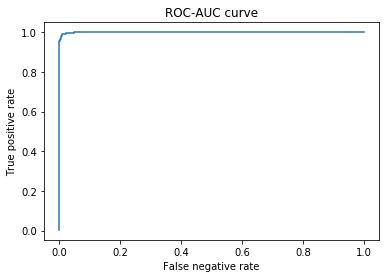

In [11]:
from sklearn.metrics import roc_curve, precision_recall_curve

fpr, tpr, _ = roc_curve(y_test, predictions)

plt.plot(fpr, tpr);
plt.title('ROC-AUC curve');
plt.xlabel('False negative rate');
plt.ylabel('True positive rate');

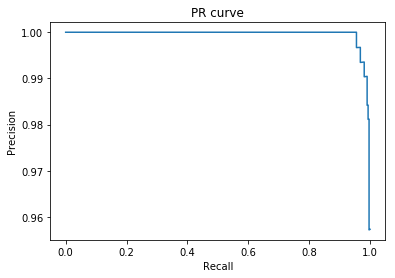

In [12]:
precision, recall, _ = precision_recall_curve(y_test, predictions)

plt.plot(recall, precision);
plt.title('PR curve');
plt.xlabel('Recall');
plt.ylabel('Precision');

### Бонусное задание. Обучение логистической регрессии.

[2 бонусных балла]

Если выше вручную мы только применяли логистическую регрессию, то здесь предлагается реализовать обучение с помощью полного градиентного спуска.

Если кратко, то обучение логистической регрессии с $L_2$-регуляризацией можно записать следующим образом:

$$
Q(w, X) = \frac{1}{l} \sum_{i=1}^{l} \log (1 + \exp(- y_i \langle w, x_i \rangle )) + \frac{\lambda_2}{2} \lVert w \rVert _2^2 \to \min_w
$$

Считаем, что $y_i \in \{-1, +1\}$, а нулевым признаком сделан единичный (то есть $w_0$ соответствует свободному члену). Искать $w$ будем с помощью градиентного спуска:

$$
w^{(k+1)} = w^{(k)} - \alpha \nabla_w Q(w, X)
$$

В случае полного градиентного спуска $\nabla_w Q(w, X)$ считается напрямую (как есть, то есть, используя все объекты выборки). Длину шага $\alpha > 0$ в рамках данного задания предлагается брать равной некоторой малой константе.

Градиент по объекту $x_i$ считается по следующей формуле:

$$
\nabla_w Q(w, x_i) = - \frac{y_i x_i}{1 + \exp(y_i \langle w, x_i \rangle)} + \lambda_2 w
$$

На самом деле неправильно регуляризировать свободный член $w_0$ (то есть при добавлении градиента для $w_0$ не надо учитывать слагаемое с $\lambda_2$). Но в рамках этого задания мы не обращаем на это внимания и работаем со всеми вектором весов одинаково. 

В качестве критерия останова необходимо использовать (одновременно):
- проверку на евклидовую норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка $10^{-6}$) — параметр tolerance
- достижение максимального числа итераций (например, 10000) — параметр max\_iter.

Инициализировать веса можно случайным образом или нулевым вектором.

Реализуйте обучение логистической регрессии. Для удобства ниже предоставлен прототип с необходимыми методами. В `loss_history` необходимо сохранять вычисленное на каждой итерации значение функции потерь. 

In [13]:
from sklearn.base import BaseEstimator

class LogReg(BaseEstimator):
    def __init__(self, lambda_2=1.0, tolerance=1e-4, max_iter=1000, alpha=1e-3):
        """
        lambda_2: L2 regularization param
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        alpha: learning rate
        """
        self.lambda_2 = lambda_2
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.alpha = alpha
        self.w = None
        self.loss_history = None
    
    def fit(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: self
        """
        self.loss_history = []
        intercept_term = np.ones((X.shape[0],1))
        X = np.hstack((intercept_term, X))
        #self.w = np.zeros((1,X.shape[1]))
        self.w = np.random.rand(1, X.shape[1])
        for i in range(self.max_iter):
            loss = self.calc_loss(X, y)
            self.loss_history.append(loss)
            grad = self.calc_gradient(X, y) 
            new_weights = self.w - self.alpha * grad
            if(np.linalg.norm(new_weights - self.w) <= self.tolerance):
                return self
            self.w = new_weights
        return self
    
    def predict_proba(self, X):
        """
        X: np.array of shape (l, d)
        ---
        output: np.array of shape (l, 2) where
        first column has probabilities of -1
        second column has probabilities of +1
        """
        intercept_term = np.ones((X.shape[0],1))
        X = np.hstack((intercept_term, X))
        if self.w is None:
            raise Exception('Not trained yet')
        scores = X.dot(self.w.T).flatten()
        raw_prediction_pos = sigmoid(scores)
        raw_prediction_neg = 1-sigmoid(scores)
        predictions = np.stack((raw_prediction_neg, raw_prediction_pos), axis=-1)
        return predictions
    
    def calc_gradient(self, X, y):
        """
        X: np.array of shape (l, d) (l can be equal to 1 if stochastic)
        y: np.array of shape (l)
        ---
        output: np.array of shape (d)
        """
        grad = np.sum(-y[:,np.newaxis]*X / (1+np.exp(y[:,np.newaxis]* X.dot(self.w.T))) + self.lambda_2 * self.w, axis =0)
        return grad

    def calc_loss(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: float 
        """ 
        return np.mean(np.log(1+np.exp(- y * X.dot(self.w.T).flatten()))) + (self.lambda_2**2 * np.linalg.norm(self.w)**2)/2

1. Примените логистическую регресиию на той же выборке.
2. Посчитайте качество по тем же метрикам.
3. Визуализируйте изменение значений функции потерь от номера итераций.

In [14]:
cust_logit = LogReg()
cust_logit.fit(X_train,y_train)

LogReg(alpha=0.001, lambda_2=1.0, max_iter=1000, tolerance=0.0001)

In [15]:
predictions = cust_logit.predict_proba(X_test)[:,1]
binary_predictions = (predictions>=0.5).astype(int)

print("ROC-AUC: ", roc_auc_score(y_test, predictions))
print("Accuracy score: ", accuracy_score(y_test,binary_predictions))

ROC-AUC:  0.996113758853
Accuracy score:  0.673333333333


Text(0,0.5,'Loss')

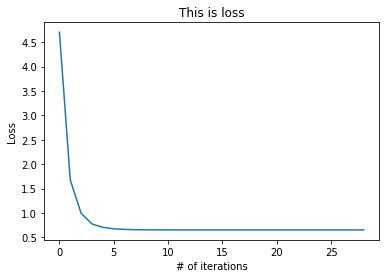

In [16]:
plt.plot(range(len(cust_logit.loss_history,)), cust_logit.loss_history)
plt.title('This is loss')
plt.xlabel('# of iterations')
plt.ylabel('Loss')

## Часть 2. Случайные леса.

[6 баллов]

Случайный лес — алгоритм машинного обучения, представляющий собой бэггинг над решающими деревьями (усреднение ответов множества слабых алгоритмов) с 2 основными идеями:
- Использование подмножества признаков при построении каждого сплита дерева.
- Бутстрап обучающей выборки для построения каждого дерева (с повторениями).

В этом задании мы попробуем оценить пользу каждой из идей. Будем использовать ту же выборку с тем же разбиением на 2 части. Для начала обучите решающее дерево `DecisionTreeClassifier` из scikit-learn и посчитайте ROC-AUC и Accuracy (порог 0.5). Не забудьте зафикиксировать сид для построения дерева (несмотря на то, что в классической реализации никакой случайности нет, при большой глубине дерева может возникать неоднозначность в выборке признака в сплите). Используйте этот сид для всех заданий ниже.

In [17]:
from sklearn.tree import DecisionTreeClassifier

simple_tree = DecisionTreeClassifier(random_state=0)
simple_tree.fit(X_train,y_train)
predictions_tree = simple_tree.predict_proba(X_test)[:,1]
predictions_tree_binary = (predictions_tree >=0.5).astype(int)

print('ROC-AUC: ', roc_auc_score(y_test,predictions_tree))
print('Accuracy: ', accuracy_score(y_test, predictions_tree_binary))

ROC-AUC:  0.955447418823
Accuracy:  0.955


### 2.1 Бэггинг классификаторов

Реализуйте бэггинг над решающими деревьями (усреднение предсказанных вероятностей всего ансамбля). 
В качестве основы используйте всё тот же `DecisionTreeClassifier`. Количество базовых алгоритмов предлагается брать равным 100. 

Посчитайте качество с помощью тех же метрик. Ответьте на следующие вопросы:
- Что интересного вы видите?
- С чем это связано?

- ROC-AUC немного увеличился по сравнению с одним деревом.
- Это связано с тем, что параметр random_state, если его не фиксировать, вносит элемент случайности в процесс разделения дерева на каждом этапе, т.е при одинаково хороших разделяющих признаках он по-разному случайным образом выбирает один из них. Это делает деревья в ансамбле немного различными и при усреднении каждое переобученное дерево компенсирует недостатки других переобученных дервьев.

In [18]:
predictions = np.zeros_like(y_test)
n_estimators = 100
predictions = []
for i in range(n_estimators):
    simple_tree = DecisionTreeClassifier()
    simple_tree.fit(X_train,y_train)
    predictions.append(simple_tree.predict(X_test))

all_preds = np.array(predictions)
predictions = np.mean(all_preds, axis=0)
predictions_binarized = (predictions >=0.5).astype(int)

print('ROC-AUC: ', roc_auc_score(y_test,predictions))
print('Accuracy: ', accuracy_score(y_test, predictions_binarized))

ROC-AUC:  0.960486169881
Accuracy:  0.955


### 2.2 Сэмплирование обучающей выборки

Добавим к нашему бэггингу бутстрап выборки (генерация случайной выборки того же размера с возвращением). Для этого может пригодиться `numpy.random.randint`.

Посчитайте качество. Что вы видите?

- Качество выросло. Деревья хоть и переобучаются, но при этом каждое переобучается под свою бутстрапированную выборку. Таким образом, их усреднение ликвидирует ошибки каждого дерева по отдельности и снижает разброс прогнозов за счет понижения ковариации между деревьями.

In [19]:
np.random.seed(123)  # для одинакового бутстрапа в каждом запуске
n_estimators = 100
trees = []
predictions = []
for i in range(n_estimators):
    simple_tree = DecisionTreeClassifier()
    indices_bootstrap = np.random.randint(0, len(X_train), size = X_train.shape[0])
    simple_tree.fit(X_train[indices_bootstrap],y_train[indices_bootstrap])
    trees.append(simple_tree)
    predictions.append(simple_tree.predict_proba(X_test)[:,1])

In [20]:
all_preds = np.array(predictions)
predictions = np.mean(all_preds, axis=0)
predictions_binarized = (predictions >=0.5).astype(int)

print('ROC-AUC: ', roc_auc_score(y_test,predictions))
print('Accuracy: ', accuracy_score(y_test, predictions_binarized))

ROC-AUC:  0.995267471382
Accuracy:  0.97


### 2.3 Выбор случайного подмножества признаков

Временно забудем о бутстрапе выборки и добавим выбор случайного подмножества признаков при построении каждого сплита. В `DecisionTreeClassifier` за это отвечает параметр `max_features`. По умолчанию он имеет значение `None`, что обозначает использование всех возможных признаков. Для задачи классификации рекоменуется использовать квадратный корень от количества признаков. Попробуйте выставить такое значение. На этот раз надо отключить фиксированный сид в построении дерева, так как иначе каждый раз мы будем выбирать одинаковые подмножества признаков. 

Посчитайте качество. Что вы видите?

- Качество по сравнению с одним деревом, опять же, выросло, т.к выбирая при каждом разделении лучший признак из случайного подпространства, мы делаем деревья в ансамбле более независимыми. При усреднении прогнозов каждое дерево обучено (в основном) по разным признакам, что дает нам в целом качественный классификатор.

In [21]:
np.random.seed(123)  # для одинакового бутстрапа в каждом запуске
n_estimators = 100
trees = []
predictions = []
for i in range(n_estimators):
    simple_tree = DecisionTreeClassifier(max_features=int(np.sqrt(X_train.shape[1])))
    simple_tree.fit(X_train,y_train)
    trees.append(simple_tree)
    predictions.append(simple_tree.predict_proba(X_test)[:,1])

In [22]:
all_preds = np.array(predictions)
predictions = np.mean(all_preds, axis=0)
predictions_binarized = (predictions >=0.5).astype(int)

print('ROC-AUC: ', roc_auc_score(y_test,predictions))
print('Accuracy: ', accuracy_score(y_test, predictions_binarized))

ROC-AUC:  0.990768785355
Accuracy:  0.95


### 2.4 = 2.2 + 2.3

Объединим два подхода (бутстрап + выбор подмножества признаков). Получим случайный лес.

Посчитайте качество. Что вы видите?

- Качество упало по сравнению с предыдущими методами. Выбирая из случайного подмножества признаков, мы теряем во многих деревьях признак, который в данном случае наиболее важен для классификации - ram. Он больше всего коррелирует с целевой переменной (корреляция сосавляет 0.81). Вдобавок к этому мы бутстрапируем выборку, что уменьшает количество различных объектов для обчения каждого дерева.

In [23]:
np.random.seed(123)  # для одинакового бутстрапа в каждом запуске
n_estimators = 100
trees = []
predictions = []
for i in range(n_estimators):
    simple_tree = DecisionTreeClassifier(max_features=int(np.sqrt(X_train.shape[1])))
    indices_bootstrap = np.random.randint(0, len(X_train), size = X_train.shape[0])
    simple_tree.fit(X_train[indices_bootstrap],y_train[indices_bootstrap])
    trees.append(simple_tree)
    predictions.append(simple_tree.predict_proba(X_test)[:,1])

In [24]:
all_preds = np.array(predictions)
predictions = np.mean(all_preds, axis=0)
predictions_binarized = (predictions >=0.5).astype(int)

print('ROC-AUC: ', roc_auc_score(y_test,predictions))
print('Accuracy: ', accuracy_score(y_test, predictions_binarized))

ROC-AUC:  0.99050153668
Accuracy:  0.941666666667


То, что мы сделали уже реализовано в `RandomForestClassifier`. Попробуйте воспользоваться им. Количество используемых деревьев передаётся в параметре `n_estimators`.

Посчитайте качество. Что вы видите?

- Аналогично с предыдущим пунктом. По сравнению с простым бутстрапированием качество упало, причины те же.

In [25]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

predictions = rf.predict_proba(X_test)[:,1]
binary_predictions = (predictions>=0.5).astype(int)

print("ROC-AUC: ", roc_auc_score(y_test, predictions))
print("Accuracy score: ", accuracy_score(y_test,binary_predictions))

ROC-AUC:  0.992433521892
Accuracy score:  0.946666666667


### 2.5 Влияние количества используемых деревьев в случайном лесе

Один из параметров случайного леса — количество деревьев, используемых в бэггинге. Оценим, как влияет этот параметр на финальное качество. Для этого обучите случайные леса с разным количество деревьев (например, перебирайте от 10 до 1000 с шагом в 10), оцените качество с помощью ROC-AUC. Постройте график зависимости ROC-AUC от количества используемых деревьев. Что вы видите?

- Качество классификации при добавлении деревьев сначала растет, но потом выходит на какое-то максимальное значение и затем остается почти постоянным, вне зависимости от количества деревьев. Стоит отметить, что в данном случае не возникает проблема переобучения.

In [26]:
n_trees = range(10,1000,10)
scores = []

for n in n_trees:
    rf = RandomForestClassifier(n_estimators=n, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    predictions = rf.predict_proba(X_test)[:,1]
    scores.append(roc_auc_score(y_test,predictions))

Text(0,0.5,'ROC-AUC')

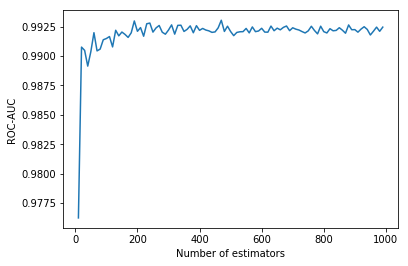

In [27]:
plt.plot(n_trees, scores)
plt.xlabel('Number of estimators')
plt.ylabel('ROC-AUC')

### 2.6 Важность признаков

Случайный лес позволяет оценить важность признаков. У обученного случайного леса есть аттрибут `feature_importances_`, где храниться важность для каждого признака. Постройте `barplot` с важностью признаков (удобно использовать библиотеку `seaborn`, где можно для каждого столбца передать название признака `train.columns`).

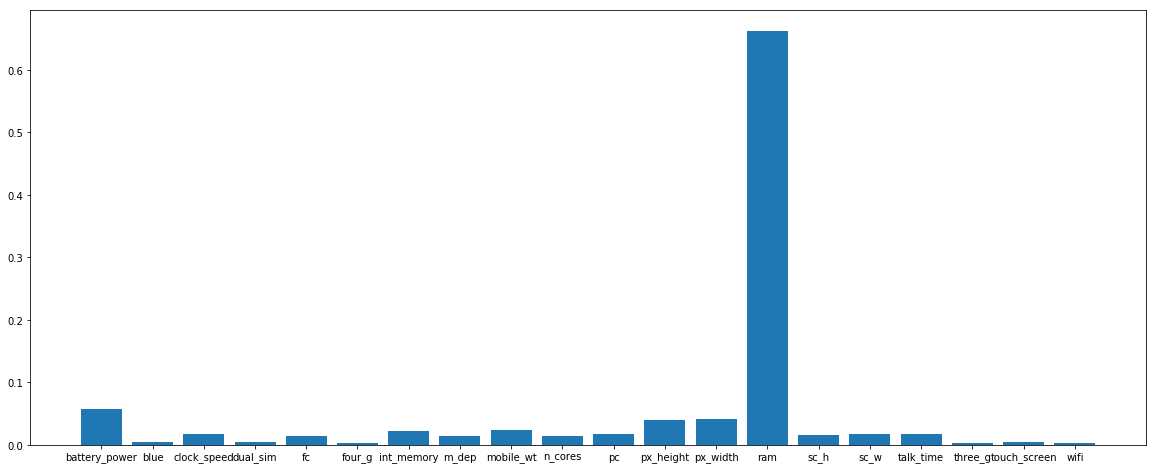

In [28]:
X_barplot = train.drop('price_range', axis=1).columns
plt.figure(figsize=(20,8))
plt.bar(range(len(rf.feature_importances_)), rf.feature_importances_)
plt.xticks(range(len(X_barplot)), X_barplot, size='medium')
plt.show()

## Выводы

Напишите, что интересного вы узнали в этой работе, в каких экспериментах какие результаты получились.

- Я более подробно выяснил, как происходит процесс выдачи прогнозов в логистической регрессии и реализовал ее сам, понял, насколько важно проводить предварительный анализ данных, чтобы увидеть, какие признаки являются наиболее информативными для предсказания целевоей переменной. Помимо этого, я разобрался с сутью случайного леса и осознал, почему сочетание бутстрэпа и метода случайных подпространств дает такие хорошие результаты. Датасет был довольно небольшой и простой по своей структуре, поэтому везде получились крайне хорошие результаты, и явно видно какой признак был наиболее важным.